Copyright 2020 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use
this file except in compliance with the License. You may obtain a copy of the
License at

[https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software distributed
under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR
CONDITIONS OF ANY KIND, either express or implied. See the License for the
specific language governing permissions and limitations under the License.


# Alchemy Environment and Analysis


This is an introduction to the environment described in the paper [**Alchemy: A structured task distribution for meta-reinforcement learning**](https://arxiv.org/pdf/2102.02926). Please see the paper for full details.

## Installation

Follow the instructions in the README.md to install dm_alchemy and dependencies. Run in jupyter or colab with a [local runtime](https://research.google.com/colaboratory/local-runtimes.html). If you use a virtual environment ensure that the python kernel for this virtual environment is being used for example by running `python -m ipykernel install --user --name=dm_alchemy` inside your virtual environment and selecting the kernel `dm_alchemy` in jupyter.


## 3d Environment


We create an instance of the 3d environment and inspect it.


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import dm_alchemy
from dm_alchemy import io
from dm_alchemy import symbolic_alchemy
from dm_alchemy import symbolic_alchemy_bots
from dm_alchemy import symbolic_alchemy_trackers
from dm_alchemy import symbolic_alchemy_wrapper
from dm_alchemy.encode import chemistries_proto_conversion
from dm_alchemy.encode import symbolic_actions_proto_conversion
from dm_alchemy.encode import symbolic_actions_pb2
from dm_alchemy.types import stones_and_potions
from dm_alchemy.types import unity_python_conversion
from dm_alchemy.types import utils

In [ ]:
width, height = 240, 200
level_name = 'alchemy/perceptual_mapping_randomized_with_rotation_and_random_bottleneck'
seed = 1023
settings = dm_alchemy.EnvironmentSettings(
    seed=seed, level_name=level_name, width=width, height=height)
env = dm_alchemy.load_from_docker(settings)

We can see that observations consist of:

*   RGB_INTERLEAVED - This is the image that the agent can see. For our experiments we set the resolution to 96x72 but here we use 240x200 so that the image is easier to interpret.
*   ACCELERATION, HAND_FORCE, HAND_IS_HOLDING, HAND_DISTANCE - These are proprioceptive observations.
*   events - This is a variable sized array of protobufs containing information from the environment which can be used for analysis but should not be used by the agent.


In [ ]:
env.observation_spec()

OrderedDict([('events',
              PartialArray(shape=(-1,), dtype=dtype('O'), name='events')),
             ('Score', Array(shape=(), dtype=dtype('float64'), name='Score')),
             ('ACCELERATION',
              Array(shape=(3,), dtype=dtype('float32'), name='ACCELERATION')),
             ('RGB_INTERLEAVED',
              Array(shape=(200, 240, 3), dtype=dtype('uint8'), name='RGB_INTERLEAVED')),
             ('HAND_FORCE',
              Array(shape=(), dtype=dtype('float32'), name='HAND_FORCE')),
             ('HAND_IS_HOLDING',
              Array(shape=(), dtype=dtype('bool'), name='HAND_IS_HOLDING')),
             ('HAND_DISTANCE',
              Array(shape=(), dtype=dtype('float32'), name='HAND_DISTANCE'))])

The actions available to the agent consist of looking left or right, up or down, moving left or right and backward or forward and actions for grabbing an object and moving it around.


In [ ]:
env.action_spec()

OrderedDict([('USE_HELD_OBJECT',
              BoundedArray(shape=(), dtype=dtype('float64'), name='USE_HELD_OBJECT', minimum=0.0, maximum=1.0)),
             ('MOVE_BACK_FORWARD',
              BoundedArray(shape=(), dtype=dtype('float64'), name='MOVE_BACK_FORWARD', minimum=-1.0, maximum=1.0)),
             ('HAND_ROTATE_AROUND_RIGHT',
              BoundedArray(shape=(), dtype=dtype('float64'), name='HAND_ROTATE_AROUND_RIGHT', minimum=-1.0, maximum=1.0)),
             ('HAND_GRIP',
              BoundedArray(shape=(), dtype=dtype('float64'), name='HAND_GRIP', minimum=0.0, maximum=1.0)),
             ('LOOK_LEFT_RIGHT',
              BoundedArray(shape=(), dtype=dtype('float64'), name='LOOK_LEFT_RIGHT', minimum=-1.0, maximum=1.0)),
             ('HAND_PUSH_PULL',
              BoundedArray(shape=(), dtype=dtype('float64'), name='HAND_PUSH_PULL', minimum=-10.0, maximum=10.0)),
             ('STRAFE_LEFT_RIGHT',
              BoundedArray(shape=(), dtype=dtype('float64'), name='STRAFE_L

Let's start a new episode and look at the image observations.


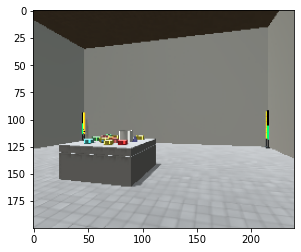

In [ ]:
timestep = env.reset()
plt.figure()
plt.imshow(timestep.observation['RGB_INTERLEAVED'])

With this seed we have started far away from the table, let's take a few actions to get closer to it.


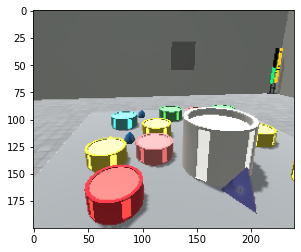

In [ ]:
for _ in range(38):
  timestep = env.step({'MOVE_BACK_FORWARD': 1.0})
for _ in range(6):
  timestep = env.step({'LOOK_LEFT_RIGHT': -1.0})
for _ in range(3):
  timestep = env.step({'LOOK_DOWN_UP': 1.0})
plt.figure()
plt.imshow(timestep.observation['RGB_INTERLEAVED'])

Now we can see the potions of different colours which can be used to transform stones to increase their value before placing them in the big white cauldron to get reward.


## Symbolic Environment


We can represent the same challenge in a symbolic form which eliminates the complex perceptual challenges, more difficult action space and longer timescales of the 3d environment.


In [ ]:
env = symbolic_alchemy.get_symbolic_alchemy_level(level_name, seed=314)

Observations from the symbolic environment are concatenated together into a single array of length 39 with 5 dimensions for each stone:

*   3 perceptual features - colour, size and roundness. These can take values -1, 0 or 1 e.g. for small, medium and large.
*   1 reward. This takes values -1, -1/3, 1/3, 1 which correspond to actual rewards -3, -1, 1, 15.
*   1 dimension which shows if the stone has been used in the cauldron. This is 0 if the stone still exists 1 otherwise. If the stone is put into the cauldron all the other dimensions are set to default values.

2 dimensions for each potion:
*   1 for colour. This takes values -1, -2/3, -1/3, 0, 1/3, 2/3 for colours red, green, orange, yellow, pink, turquoise.
*   1 dimension which shows if the potion has been used by placing a stone in it. This is 0 if the potion is still full, 1 otherwise. If the potion is used the colour dimension is set to a default value.


In [ ]:
env.observation_spec()

{'symbolic_obs': Array(shape=(39,), dtype=dtype('float32'), name='symbolic_obs')}

There are 40 possible actions in the symbolic environment which are selected using an int between 0 and 39.

These are:

*   0 represents doing nothing
*   The remaining integers represent putting a stone into a potion or into the cauldron, i.e. s * (num potion slots (= 12) + 1) + 1 represents putting the stone in slot s (from 0 - 2) into the cauldron and s * (num potion slots (= 12) + 1) + 2 + p represents putting stone s into the potion in slot p (from 0 - 11). For example putting stone 1 into potion 5 is represented by action 20.


In [ ]:
env.action_spec()

BoundedArray(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=39)

For example with this seed we start with stone 0 being purple, small and halfway between round and pointy and its reward indicator shows a -1. Potion 0 is turquoise.


In [ ]:
timestep = env.reset()
timestep.observation['symbolic_obs']

array([-1.        , -1.        ,  0.        , -0.33333334,  0.        ,
        0.        , -1.        ,  1.        ,  0.33333334,  0.        ,
       -1.        ,  1.        ,  0.        , -1.        ,  0.        ,
        0.6666667 ,  0.        ,  0.6666667 ,  0.        , -0.6666667 ,
        0.        , -0.6666667 ,  0.        ,  0.33333334,  0.        ,
        0.        ,  0.        , -0.6666667 ,  0.        ,  0.        ,
        0.        , -0.6666667 ,  0.        ,  0.33333334,  0.        ,
        0.        ,  0.        , -0.33333334,  0.        ], dtype=float32)

If we put stone 0 into potion 0 and look at the resulting observation we can see that stone 0 has become purple, large and halfway between round and pointy and its reward indicator shows -3. From this an agent which understands the task and the generative process can deduce things like: 

*   The turquoise potion makes stones large.
*   The pink potion makes stones small (because it is always paired with the turquoise potion).
*   The blue, small, halfway between round and pointy stone has maximum value (because it is in the opposite corner to the stone we have observed to have the minimum possible value).


In [ ]:
timestep = env.step(2)
timestep.observation['symbolic_obs']

array([-1.        ,  1.        ,  0.        , -1.        ,  0.        ,
        0.        , -1.        ,  1.        ,  0.33333334,  0.        ,
       -1.        ,  1.        ,  0.        , -1.        ,  0.        ,
        1.        ,  1.        ,  0.6666667 ,  0.        , -0.6666667 ,
        0.        , -0.6666667 ,  0.        ,  0.33333334,  0.        ,
        0.        ,  0.        , -0.6666667 ,  0.        ,  0.        ,
        0.        , -0.6666667 ,  0.        ,  0.33333334,  0.        ,
        0.        ,  0.        , -0.33333334,  0.        ], dtype=float32)

## Combined environment


We can create an environment which is a combination of the 3d environment and the symbolic environment by using a wrapper around the 3d environment which listens to the events output and uses them to initialise and take actions in a symbolic environment to keep it in sync with the 3d environment. In this setting the agent takes actions in the 3d environment and recieves observations from the 3d environment but can also optionally receive observations that are only produced by the symbolic environment.


In [ ]:
seed = 1023
settings = dm_alchemy.EnvironmentSettings(
    seed=seed, level_name=level_name, width=width, height=height)
env3d = dm_alchemy.load_from_docker(settings)
env = symbolic_alchemy_wrapper.SymbolicAlchemyWrapper(
    env3d, level_name=level_name, see_symbolic_observation=True)

Using the same seed as before we create the environment and go and look at the table.


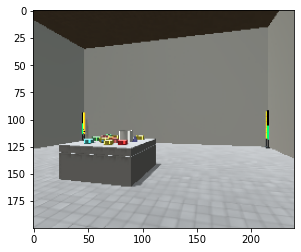

In [ ]:
timestep = env.reset()
plt.figure()
plt.imshow(timestep.observation['RGB_INTERLEAVED'])

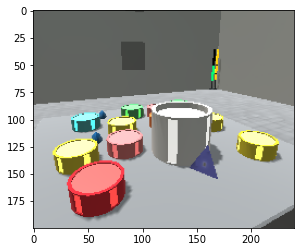

In [ ]:
for _ in range(37):
  timestep = env.step({'MOVE_BACK_FORWARD': 1.0})
for _ in range(4):
  timestep = env.step({'LOOK_LEFT_RIGHT': -1.0})
for _ in range(3):
  timestep = env.step({'LOOK_DOWN_UP': 1.0})
plt.figure()
plt.imshow(timestep.observation['RGB_INTERLEAVED'])

Although a few potions are occluded, if we look at the picture above we can see that the symbolic observations match. i.e. we have:
*   2 stones which are blue, small with medium roundness
*   1 stone which is midway between blue and purple, large and pointy.

The potion colours also match.


In [ ]:
print('Stones:')
for i in range(0, 15, 5):
  print(timestep.observation['symbolic_obs'][i:i + 5])
print('Potions:')
for i in range(15, 39, 2):
  potion_index = int(round(timestep.observation['symbolic_obs'][i] * 3 + 3))
  potion = stones_and_potions.perceived_potion_from_index(potion_index)
  print(unity_python_conversion.POTION_COLOUR_AT_PERCEIVED_POTION[potion])

Stones:
[ 1.         -1.          0.          0.33333334  0.        ]
[ 0.          1.         -1.          0.33333334  0.        ]
[ 1.         -1.          0.          0.33333334  0.        ]
Potions:
green
yellow
yellow
orange
turquoise
red
pink
yellow
yellow
yellow
pink
green


## Additional Observations


With the symbolic or combined environment we can get additional observations of the ground thruth chemistry or a belief state over the chemistry. 


### Ground Truth Chemistry


The ground truth chemistry observation consists of 4 parts:

*   Graph - this consists of 12 entries for the 12 edges on the graph, each entry is set to 0 if there is no edge or 1 if there is an edge.
*   The potion map - this is a 1 hot vector over the 6 possible assignments of potion colour pairs to latent space dimensions (called the dimension map) and then a 3 dimensional direction map (i.e. we assume a canonical direction for each potion colour pair and this value will be 1 if this is the direction in latent space or 0 if it is the reverse, e.g. if the red potion increases the value of the latent variable and the green potion decreases it this entry is set to 1, if the green potion increases the value of the latent variable and the red potion decreases this is set to 0).
*   Stone map - this is another 3 dimensional direction map (e.g. if a large size stone has a higher latent variable than a small size stone then the entry is set to 1, otherwise it is set to 0 etc).
*   Rotation - this is a 1 hot vector over the 4 possible rotations (no rotation or 45 degrees around x, y or z).
  
In total this is a 28 dimensional observation (12 + 6 + 3 + 3 + 4).


In [ ]:
seed = 789
env = symbolic_alchemy.get_symbolic_alchemy_level(
    level_name, seed=seed, 
    see_chemistries={
        'input_chem': utils.ChemistrySeen(
            content=utils.ElementContent.GROUND_TRUTH)
        })

In [ ]:
env.observation_spec()

{'symbolic_obs': Array(shape=(39,), dtype=dtype('float32'), name='symbolic_obs'),
 'input_chem': Array(shape=(28,), dtype=dtype('float32'), name='input_chem')}

In [ ]:
timestep = env.reset()
input_chem = timestep.observation['input_chem']
print('Graph:', input_chem[:12])
print('Potion map dimension map:', input_chem[12:18])
print('Potion map direction map:', input_chem[18:21])
print('Stone map direction map:', input_chem[21:24])
print('Rotation:', input_chem[24:])

Graph: [1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0.]
Potion map dimension map: [0. 0. 0. 0. 1. 0.]
Potion map direction map: [1. 0. 0.]
Stone map direction map: [0. 0. 1.]
Rotation: [1. 0. 0. 0.]


### Belief state


We can also maintain a belief state over the underlying chemistry. This is a probability distribution over all possible chemistries which could be present in the current episode. 

The belief state is updated to perfectly incorporate all information available to the agent both through:

*   Infinite training on the task distribution.
*   Observations within the current episode.

The first form of information means that with no other information the belief state starts as a prior distribution over all possible chemistries which accurately reflects the generative distribution. 

The second form of information means that the belief state is correctly updated to eliminate chemistries which are inconsistent with observations during the episode and rescale the resulting distribution. 

As soon as the agent is presented with a set of stones, it can rule out some chemistries. For example, some rotations will not include the stones that are present and the reward indicator on each stone can eliminate some of the possible stone maps.

As the agent takes actions in the environment the belief state is further updated. For example, if a small stone becomes large when put into a green potion all chemistries but those where red and green potions are mapped to the size variable and the green potion increases the size can be eliminated. 

The belief state observation is a relaxation of the ground truth observation in which the values from the ground truth observation are used if the belief state assigns all probability to that possibility.

*   The graph - if the presence of an edge is unknown then the corresponding entry is set to 0.5.
*   The potion map - for the dimension map if the correct assignment is unknown then all possibilities are set to 0.5, for the direction map if the true direction for that dimension is unknown then we set the entry to 0.5.
*   The stone map - this is another direction map so this works the same way as in the potion map.
*   Rotation - if multiple rotations are possibile then the entry corresponding to each possibile rotation is set to 0.5.


In [ ]:
seed = 22
env = symbolic_alchemy.get_symbolic_alchemy_level(
    level_name, seed=seed, 
    see_chemistries={
        'input_chem': utils.ChemistrySeen(
            content=utils.ElementContent.BELIEF_STATE,
            precomputed=level_name)
        })

Before any actions are taken the presence of each edge in the graph is unknown and nothing is known about the potion map.

However, the stones present narrow down the possible rotations and stone maps. The stones present are:
*   blue, small, medium roundness with reward 1
*   purple, small, medium roundness with reward 1
*   blue, large, medium roundness with reward -1

There cannot be medium roundness stones in the unrotated chemistry or the chemistry which is rotated around the roundness axis so these are ruled out. The chemistry which is rotated around the colour axis can also be ruled out because the first and second stones differ only in colour and have the same reward. The chemistry which is rotated around the colour axis has 1 latent variable aligned with change in colour so 2 stones which are the same size and roundness but different colour must have different reward. Therefore, the rotation is known to be around the size axis.

Since the second and third stones differ only in size and the small stone has higher reward we can also determine in the stone map that increasing size decreases the value of the associated latent variable.


In [ ]:
timestep = env.reset()
print('Stones:')
for i in range(0, 15, 5):
  print(timestep.observation['symbolic_obs'][i:i + 5])
input_chem = timestep.observation['input_chem']
print('Graph:', input_chem[:12])
print('Potion map dimension map:', input_chem[12:18])
print('Potion map direction map:', input_chem[18:21])
print('Stone map direction map:', input_chem[21:24])
print('Rotation:', input_chem[24:])

Stones:
[ 1.         -1.          0.          0.33333334  0.        ]
[-1.         -1.          0.          0.33333334  0.        ]
[ 1.          1.          0.         -0.33333334  0.        ]
Graph: [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Potion map dimension map: [0.5 0.5 0.5 0.5 0.5 0.5]
Potion map direction map: [0.5 0.5 0.5]
Stone map direction map: [0.5 0.  0.5]
Rotation: [0. 0. 1. 0.]


When one of the stones is transformed by a potion the belief state updates to reflect that the corresponding edge in the graph is known to exist. 

The potion dimension maps are narrowed down to 2 possibilities since this action has shown us the assignment of one pair of potions to one latent space axis but the other 2 potion pairs could be assigned to either of the remaining 2 latent space axes.

The potion direction map is updated on one dimension to reflect whether the potion used changed the associated latent variable in the canonical direction assigned to the pair of potions (e.g. that for the green and red pair that green is positive and red is negative).


In [ ]:
timestep = env.step(3)
print('Stones:')
for i in range(0, 15, 5):
  print(timestep.observation['symbolic_obs'][i:i + 5])
input_chem = timestep.observation['input_chem']
print('Graph:', input_chem[:12])
print('Potion map dimension map:', input_chem[12:18])
print('Potion map direction map:', input_chem[18:21])
print('Stone map direction map:', input_chem[21:24])
print('Rotation:', input_chem[24:])

Stones:
[ 0.         -1.         -1.         -0.33333334  0.        ]
[-1.         -1.          0.          0.33333334  0.        ]
[ 1.          1.          0.         -0.33333334  0.        ]
Graph: [0.5 0.5 0.5 0.5 1.  0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Potion map dimension map: [0.5 0.  0.5 0.  0.  0. ]
Potion map direction map: [0.5 0.5 1. ]
Stone map direction map: [0.5 0.  1. ]
Rotation: [0. 0. 1. 0.]


## Symbolic Alchemy Trackers


We can add trackers to the symbolic environment which have callbacks which are executed when the environment is reset or a step is taken.

We provide implementations of trackers which:

*   Keep a record of the symbolic actions that occurred in a matrix
*   Keep track of the stones and potions generated each trial
*   Keep track of the number of potions and stones used
*   Keep track of the score achieved
*   Update the belief state
*   Track the average value of stones put into the cauldron
*   Track the average improvement of the value of stones before they are put into the cauldron
*   Track the frequency of putting negative stones into the cauldron
*   Track the frequency of leaving stones with a specified reward (e.g. +1) on the table at the end of a trial
*   Track the frequency of actions where a stone is put into a potion which has no effect on the stone


We initialise the environment with the same seed as above and add a few of the above trackers. We then put the first stone into the first 2 potions and then into the cauldron and then end the trial by taking the "no operation" action for the rest of the trial.


In [ ]:
seed = 22
env = symbolic_alchemy.get_symbolic_alchemy_level(level_name, seed=seed)
env.add_trackers({
    symbolic_alchemy_trackers.ItemGeneratedTracker.NAME: 
        symbolic_alchemy_trackers.ItemGeneratedTracker(),
    symbolic_alchemy_trackers.ItemsUsedTracker.NAME: 
        symbolic_alchemy_trackers.ItemsUsedTracker(),
    symbolic_alchemy_trackers.ScoreTracker.NAME: 
        symbolic_alchemy_trackers.ScoreTracker(env._reward_weights),
    })

In [ ]:
timestep = env.reset()
timestep = env.step_slot_based_action(utils.SlotBasedAction(
    stone_ind=0, potion_ind=0))
timestep = env.step_slot_based_action(utils.SlotBasedAction(
    stone_ind=0, potion_ind=1))
timestep = env.step_slot_based_action(utils.SlotBasedAction(
    stone_ind=0, cauldron=True))
_ = env.end_trial()

The returns from the trackers show the potions and stones generated and show that 1 stone and 2 potion were used and that the score achieved was -1 (because that was the value of the stone put into the cauldron).


In [ ]:
episode_returns = env.episode_returns()
print(episode_returns['items_generated'].trials[0])
print(episode_returns['items_used']['per_trial'][0])
print(episode_returns['score']['per_trial'][0])

TrialItems(potions=[Potion(idx=0, dimension=0, direction=-1), Potion(idx=1, dimension=2, direction=-1), Potion(idx=2, dimension=2, direction=1), Potion(idx=3, dimension=1, direction=-1), Potion(idx=4, dimension=2, direction=-1), Potion(idx=5, dimension=2, direction=1), Potion(idx=6, dimension=0, direction=-1), Potion(idx=7, dimension=1, direction=-1), Potion(idx=8, dimension=2, direction=1), Potion(idx=9, dimension=1, direction=-1), Potion(idx=10, dimension=0, direction=1), Potion(idx=11, dimension=0, direction=-1)], stones=[Stone(idx=0, latent=[-1 1 1]), Stone(idx=1, latent=[1 1 -1]), Stone(idx=2, latent=[-1 -1 1])])
[2 1]
-1


## Symbolic Bots


We provide the following hand-coded policies for acting with the symbolic environment:

*   Random action bot - this bot randomly selects any stone which does not have the maximum possible value and puts it into randomly selected potions until either all potions are used or all stones have the maximum value. Then it puts any positive stones into the cauldron.
*   Search oracle bot - this bot is given the chemistry for the episode and exhaustively searches all possible actions to maximise the reward it will obtain.
*   Ideal observer bot - this bot maintains a belief state (as described above) and exhaustively searches over all possible actions and all possible outcomes of those actions using the belief state to track the probability of each outcome to maximise the expected reward it will obtain in the current trial.
*   Replay bot - this bot takes a record of actions taken and takes them again. This can be used to replay the actions an agent or another bot took to perform additional tracking.


In [ ]:
env = symbolic_alchemy.get_symbolic_alchemy_level(level_name)
env.add_trackers({
    symbolic_alchemy_trackers.ScoreTracker.NAME:
        symbolic_alchemy_trackers.ScoreTracker(env._reward_weights)
    })
bot = symbolic_alchemy_bots.RandomActionBot(env._reward_weights, env)
bot_returns = bot.run_episode()
bot_returns['score']['per_trial']

(16, 1, 0, 1, 3, 31, 45, 30, 1, 45)

## Evaluation Episodes


We have released a set of 1000 episodes on which we evaluated our agents. Each episode consists of a chemistry and a set of stones and potions generated at the start of each trial.


In [ ]:
chems = chemistries_proto_conversion.load_chemistries_and_items(
    'chemistries/perceptual_mapping_randomized_with_random_bottleneck/chemistries')

To run symbolic alchemy on these evaluation episodes the function `get_symbolic_alchemy_fixed` can be used.


In [ ]:
env = symbolic_alchemy.get_symbolic_alchemy_fixed(
    chemistry=chems[0][0], episode_items=chems[0][1])
env.add_trackers({
    symbolic_alchemy_trackers.ItemGeneratedTracker.NAME:
        symbolic_alchemy_trackers.ItemGeneratedTracker()})
env.reset()
env.end_trial()
first_trial_items = env.episode_returns()[symbolic_alchemy_trackers.ItemGeneratedTracker.NAME].trials[0]
assert first_trial_items == chems[0][1].trials[0]
assert env._chemistry == chems[0][0]

To run the 3d environment on the evaluation episodes we have included them as named levels alchemy/evaluation_episodes/{episode_number}.


In [ ]:
settings = dm_alchemy.EnvironmentSettings(
    seed=seed, level_name='alchemy/evaluation_episodes/0', width=width, height=height)
env3d = dm_alchemy.load_from_docker(settings)
env = symbolic_alchemy_wrapper.SymbolicAlchemyWrapper(
    env3d, level_name=level_name, see_symbolic_observation=True)
env.env_symbolic.add_trackers({
    symbolic_alchemy_trackers.ItemGeneratedTracker.NAME:
        symbolic_alchemy_trackers.ItemGeneratedTracker()})
env.reset()
# We need to take a step or 2 to ensure that the trial has started.
for _ in range(2):
  env.step({})

# Let the symbolic environment trial end now so we can test the items generated were as expected.
env.env_symbolic.end_trial()
first_trial_items = env.env_symbolic.episode_returns()[symbolic_alchemy_trackers.ItemGeneratedTracker.NAME].trials[0]
first_trial_potions = {p.latent_potion() for p in first_trial_items.potions}
first_trial_stones = {s.latent_stone() for s in first_trial_items.stones}
chem_first_trial_potions = {p.latent_potion() for p in chems[0][1].trials[0].potions}
chem_first_trial_stones = {s.latent_stone() for s in chems[0][1].trials[0].stones}
assert first_trial_potions == chem_first_trial_potions
assert first_trial_stones == chem_first_trial_stones
assert env.env_symbolic._chemistry == chems[0][0]

Whilst you can run the ideal observer and search oracle yourself these bots (particularly the ideal observer) are slow on full size trials of 12 potions and 3 stones, due to the size of the exhaustive search performed. However, we have included in the release the symbolic actions taken on the evaluation episodes. So you can perform analysis and, for example, compare agent actions to those of the ideal observer.


In [ ]:
serialized = io.read_proto('agent_events/ideal_observer')
proto = symbolic_actions_pb2.EvaluationSetEvents.FromString(serialized)
ideal_observer_events = symbolic_actions_proto_conversion.proto_to_evaluation_set_events(proto)

env = symbolic_alchemy.get_symbolic_alchemy_fixed(
    chemistry=chems[0][0], episode_items=chems[0][1])
env.add_trackers({
    symbolic_alchemy_trackers.ScoreTracker.NAME:
        symbolic_alchemy_trackers.ScoreTracker(env._reward_weights)})
bot = symbolic_alchemy_bots.ReplayBot(ideal_observer_events[0], env)

episode_results = bot.run_episode()
episode_results['score']['per_trial']

(1, 16, 31, 3, 30, 45, 17, 2, 45, 17)

## Plotting performance


We can compare agent's performance on the 1000 evaluation episodes to the ideal observer, search oracle and random action bot. New agents can also be added to these performance plots by simply running on the 1000 evaluation episodes with `AddMatrixEventTracker` added to the environment. The events for 3 task settings are included in the repository. Events for agents run on other settings can be downloaded at https://storage.googleapis.com/dm-alchemy/agent_events.tar.gz.

In [ ]:
loaded_events = {}
for name, events_file in [('ideal_observer', 'agent_events/ideal_observer'),
                          ('search_oracle', 'agent_events/search_oracle'),
                          ('baseline', 'agent_events/baseline'),
                          ('belief_state_predict', 'agent_events/belief_state_predict'),
                          ('ground_truth_predict', 'agent_events/ground_truth_predict')]:
  serialized = io.read_proto(events_file)
  proto = symbolic_actions_pb2.EvaluationSetEvents.FromString(serialized)
  events = symbolic_actions_proto_conversion.proto_to_evaluation_set_events(proto)
  loaded_events[name] = events

In [ ]:
random_action_events = []
for chem, items in chems:
  env = symbolic_alchemy.get_symbolic_alchemy_fixed(
      chemistry=chem, episode_items=items)
  env.add_trackers({
      symbolic_alchemy_trackers.AddMatrixEventTracker.NAME:
          symbolic_alchemy_trackers.AddMatrixEventTracker()})
  bot = symbolic_alchemy_bots.RandomActionBot(env._reward_weights, env)
  episode_results = bot.run_episode()
  random_action_events.append(episode_results['matrix_event']['event_tracker'])

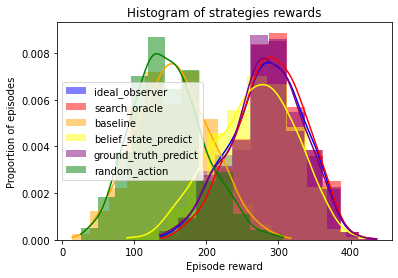

In [ ]:
plt.figure()
for name, events, colour in [
    ('ideal_observer', loaded_events['ideal_observer'], 'blue'),
    ('search_oracle', loaded_events['search_oracle'], 'red'),
    ('baseline', loaded_events['baseline'], 'orange'),
    ('belief_state_predict', loaded_events['belief_state_predict'], 'yellow'),
    ('ground_truth_predict', loaded_events['ground_truth_predict'], 'purple'),
    ('random_action', random_action_events, 'green')]:
  scores = []
  for (chem, items), ep_events in zip(chems, events):
    env = symbolic_alchemy.get_symbolic_alchemy_fixed(
      chemistry=chem, episode_items=items)
    env.add_trackers({
        symbolic_alchemy_trackers.ScoreTracker.NAME:
            symbolic_alchemy_trackers.ScoreTracker(env._reward_weights)})
    bot = symbolic_alchemy_bots.ReplayBot(ep_events, env)

    episode_results = bot.run_episode()
    scores.append(np.sum(episode_results['score']['per_trial']))
  sns.histplot(scores, label=name, bins=12, kde=True, edgecolor=None, 
               stat='density', color=colour)
plt.xlabel('Episode reward')
plt.ylabel('Proportion of episodes')
plt.title('Histogram of strategies rewards')
plt.legend()
plt.show()